# Employee Attrition Analysis – Jaya Jaya Maju

_Capstone submission – **Malikusfz**_

- **Name**: Maliku Syafaadi Nurfaza
- **Email**: malikussyafaadinurfaza@gmail.com   
- **Dicoding ID**: Malikusfz

## 1 Business Understanding
Perusahaan mengalami attrition > 10 % (> 6 % rata‑rata industri).
Target proyek:
1. Identifikasi driver attrition.
2. Dashboard real‑time HR.
3. Model prediksi karyawan berisiko keluar.

## 2 Data Preparation

### 2.1 Import Libraries

In [ ]:
import warnings, os, json, joblib, optuna, numpy as np, pandas as pd
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt, seaborn as sns
sns.set_theme(style='whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
from category_encoders.target_encoder import TargetEncoder

from catboost import CatBoostClassifier, Pool, cv

d:\IDCamp\Mahir\#1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.2 Load Dataset

In [63]:
DATA_PATH = 'employee_data.csv'
TARGET    = 'Attrition'

df = pd.read_csv(DATA_PATH).dropna(subset=[TARGET])
print('Shape:', df.shape)
df.head()

Shape: (1058, 35)


,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1,2,37,1.0,Travel_Rarely,1141,Research & Development,11,2,Medical,1,...,1,80,0,15,2,1,1,0,0,0
2,3,51,1.0,Travel_Rarely,1323,Research & Development,4,4,Life Sciences,1,...,3,80,3,18,2,4,10,0,2,7
3,4,42,0.0,Travel_Frequently,555,Sales,26,3,Marketing,1,...,4,80,1,23,2,4,20,4,4,8
6,7,40,0.0,Travel_Rarely,1124,Sales,1,2,Medical,1,...,3,80,3,6,2,2,4,3,0,2
7,8,55,1.0,Travel_Rarely,725,Research & Development,2,3,Medical,1,...,4,80,1,24,2,3,5,2,1,4


### 2.3 Feature Engineering

In [ ]:
cat_cols = df.select_dtypes('object').columns.tolist()
num_cols = [c for c in df.columns if c not in cat_cols + [TARGET]]

df['TenureBucket'] = pd.cut(df['YearsAtCompany'], [0,2,5,10,40], labels=False)
df['AgeBucket']    = pd.cut(df['Age'], [17,25,35,45,60], labels=False)

df['OT_JobLevel']  = df['OverTime'] + '_' + df['JobLevel'].astype(str)
df['IncomePerYear']= df['MonthlyIncome'] / (df['TotalWorkingYears']+1)

cat_cols += ['TenureBucket','AgeBucket','OT_JobLevel']
num_cols += ['IncomePerYear']
print('Categorical:', len(cat_cols),'| Numerical:', len(num_cols))

Categorical: 11 | Numerical: 27


## 3 Exploratory Data Analysis

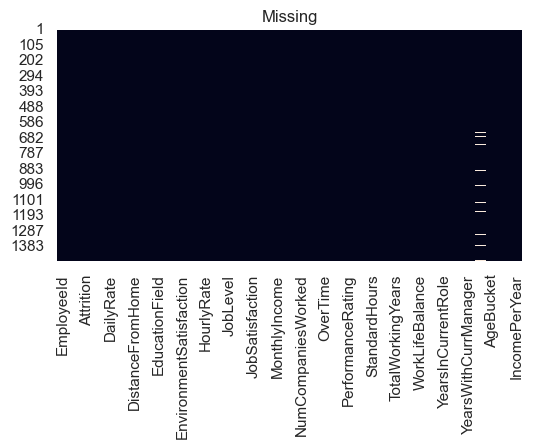

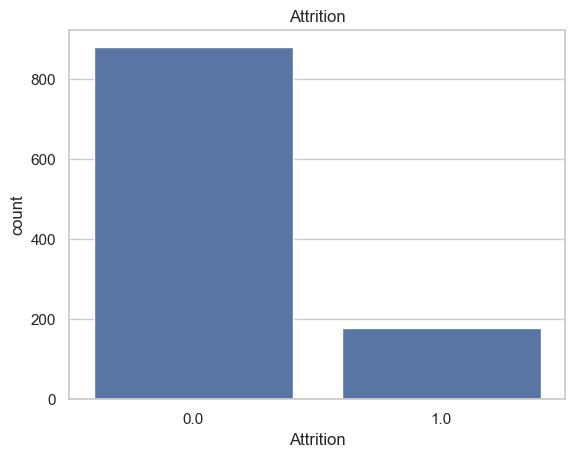

Attrition
0.0    83.081285
1.0    16.918715
Name: proportion, dtype: float64

In [ ]:
plt.figure(figsize=(6,3)); sns.heatmap(df.isna(), cbar=False); plt.title('Missing'); plt.show()

sns.countplot(x=TARGET, data=df); plt.title('Attrition'); plt.show()
df[TARGET].value_counts(normalize=True)*100

In [66]:
# Numerical describe
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
EmployeeId,1058.0,736.656900,427.440538,2.0,364.250000,731.500000,1117.750000,1470.0
Age,1058.0,37.055766,9.410421,18.0,30.000000,36.000000,43.000000,60.0
DailyRate,1058.0,809.542533,408.478049,102.0,465.250000,817.500000,1168.500000,1499.0
DistanceFromHome,1058.0,8.978261,8.040608,1.0,2.000000,7.000000,13.000000,29.0
Education,1058.0,2.879017,1.031442,1.0,2.000000,3.000000,4.000000,5.0
EmployeeCount,1058.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0
EnvironmentSatisfaction,1058.0,2.712665,1.092959,1.0,2.000000,3.000000,4.000000,4.0
HourlyRate,1058.0,65.643667,20.324861,30.0,48.000000,65.000000,83.000000,100.0
JobInvolvement,1058.0,2.737240,0.704730,1.0,2.000000,3.000000,3.000000,4.0
JobLevel,1058.0,2.090737,1.136514,1.0,1.000000,2.000000,3.000000,5.0


## 4 Modeling – CatBoost + Optuna

In [ ]:
X, y = df.drop(columns=[TARGET]), df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)

te_cols  = [c for c in cat_cols if X_train[c].nunique()>10]
ohe_cols = [c for c in cat_cols if c not in te_cols]

def fit_encode(X_df, y_series):
    enc = TargetEncoder(cols=te_cols).fit(X_df, y_series)
    X_ = enc.transform(X_df)
    X_ = pd.get_dummies(X_, columns=ohe_cols, drop_first=True)
    return X_, enc

def apply_encode(X_df, enc, ref_cols):
    X_ = enc.transform(X_df)
    X_ = pd.get_dummies(X_, columns=ohe_cols, drop_first=True)
    missing = [c for c in ref_cols if c not in X_.columns]
    for c in missing: X_[c]=0
    return X_[ref_cols]

X_train_enc, encoder = fit_encode(X_train, y_train)
X_test_enc           = apply_encode(X_test, encoder, X_train_enc.columns)

In [ ]:
train_pool = Pool(X_train_enc, y_train)

def objective(trial):
    params = {
        "depth"             : trial.suggest_int("depth",4,8),
        "learning_rate"     : trial.suggest_float("learning_rate",0.02,0.15,log=True),
        "l2_leaf_reg"       : trial.suggest_float("l2_leaf_reg",1,10,log=True),
        "random_strength"   : trial.suggest_float("random_strength",0,2),
        "bagging_temperature": trial.suggest_float("bagging_temperature",0,1),
        "border_count"      : trial.suggest_int("border_count",64,255),

        "loss_function" : "Logloss",
        "eval_metric"   : "AUC",
        "iterations"    : 1500,
        "verbose"       : 0,
        "random_seed"   : 42,
        "class_weights" : [1, y_train.value_counts()[0]/y_train.value_counts()[1]]
    }
    cv_res = cv(train_pool, params, fold_count=3, stratified=True, verbose=False)
    return np.max(cv_res['test-AUC-mean'])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=1800)

[I 2025-04-18 21:50:18,052] A new study created in memory with name: no-name-55a37ad8-b022-4a41-b63b-d31d2735587b


Training on fold [0/3]

bestTest = 0.792641844
bestIteration = 689

Training on fold [1/3]

bestTest = 0.8204237892
bestIteration = 31

Training on fold [2/3]


[I 2025-04-18 21:50:38,136] Trial 0 finished with value: 0.7739794861692024 and parameters: {'depth': 7, 'learning_rate': 0.10776419788523965, 'l2_leaf_reg': 7.7403918333465, 'random_strength': 0.07882250899994547, 'bagging_temperature': 0.7359548477040453, 'border_count': 140}. Best is trial 0 with value: 0.7739794861692024.



bestTest = 0.7447717767
bestIteration = 1443

Training on fold [0/3]

bestTest = 0.8041666667
bestIteration = 1423

Training on fold [1/3]

bestTest = 0.7818732194
bestIteration = 28

Training on fold [2/3]


[I 2025-04-18 21:51:04,102] Trial 1 finished with value: 0.764442651189105 and parameters: {'depth': 8, 'learning_rate': 0.08827028493711256, 'l2_leaf_reg': 8.090946687512245, 'random_strength': 0.2571343071616701, 'bagging_temperature': 0.8591286743484755, 'border_count': 174}. Best is trial 0 with value: 0.7739794861692024.



bestTest = 0.7411347518
bestIteration = 113

Training on fold [0/3]

bestTest = 0.7935283688
bestIteration = 79

Training on fold [1/3]

bestTest = 0.8024394587
bestIteration = 50

Training on fold [2/3]


[I 2025-04-18 21:51:19,967] Trial 2 finished with value: 0.7722175496554929 and parameters: {'depth': 5, 'learning_rate': 0.0661348874797082, 'l2_leaf_reg': 7.004968937779891, 'random_strength': 0.044341293386930936, 'bagging_temperature': 0.8592726305600851, 'border_count': 136}. Best is trial 0 with value: 0.7739794861692024.



bestTest = 0.7375886525
bestIteration = 66

Training on fold [0/3]

bestTest = 0.8171985816
bestIteration = 114

Training on fold [1/3]

bestTest = 0.8220263533
bestIteration = 92

Training on fold [2/3]


[I 2025-04-18 21:51:33,033] Trial 3 finished with value: 0.7913100361681922 and parameters: {'depth': 4, 'learning_rate': 0.041473634027155586, 'l2_leaf_reg': 8.069105139611656, 'random_strength': 0.40028104072104864, 'bagging_temperature': 0.038932563377349516, 'border_count': 113}. Best is trial 3 with value: 0.7913100361681922.



bestTest = 0.7443171486
bestIteration = 19

Training on fold [0/3]

bestTest = 0.8078014184
bestIteration = 210

Training on fold [1/3]

bestTest = 0.8110754986
bestIteration = 121

Training on fold [2/3]


[I 2025-04-18 21:51:55,064] Trial 4 finished with value: 0.7894407569052958 and parameters: {'depth': 7, 'learning_rate': 0.11796127181298659, 'l2_leaf_reg': 4.4279616510983475, 'random_strength': 1.1055449968555335, 'bagging_temperature': 0.1422732775868859, 'border_count': 174}. Best is trial 3 with value: 0.7913100361681922.



bestTest = 0.7631387525
bestIteration = 67

Training on fold [0/3]

bestTest = 0.8127659574
bestIteration = 49

Training on fold [1/3]

bestTest = 0.8149038462
bestIteration = 98

Training on fold [2/3]


[I 2025-04-18 21:52:15,677] Trial 5 finished with value: 0.786191807601382 and parameters: {'depth': 7, 'learning_rate': 0.0830219951447643, 'l2_leaf_reg': 1.2057854278484932, 'random_strength': 1.9338535335684295, 'bagging_temperature': 0.8884442487773533, 'border_count': 213}. Best is trial 3 with value: 0.7913100361681922.



bestTest = 0.7432260411
bestIteration = 324

Training on fold [0/3]

bestTest = 0.7884751773
bestIteration = 111

Training on fold [1/3]

bestTest = 0.7938924501
bestIteration = 52

Training on fold [2/3]


[I 2025-04-18 21:52:29,821] Trial 6 finished with value: 0.7719520973510335 and parameters: {'depth': 4, 'learning_rate': 0.0348129989893045, 'l2_leaf_reg': 2.791613383924743, 'random_strength': 0.006282959391170628, 'bagging_temperature': 0.6213962356096328, 'border_count': 248}. Best is trial 3 with value: 0.7913100361681922.



bestTest = 0.7414984543
bestIteration = 97

Training on fold [0/3]

bestTest = 0.7855496454
bestIteration = 222

Training on fold [1/3]

bestTest = 0.8140135328
bestIteration = 40

Training on fold [2/3]


[I 2025-04-18 21:52:45,123] Trial 7 finished with value: 0.7765411893071468 and parameters: {'depth': 5, 'learning_rate': 0.021234101192028124, 'l2_leaf_reg': 7.246219666637084, 'random_strength': 0.19637445008542143, 'bagging_temperature': 0.8700238951765109, 'border_count': 184}. Best is trial 3 with value: 0.7913100361681922.



bestTest = 0.7500454628
bestIteration = 308

Training on fold [0/3]

bestTest = 0.8310283688
bestIteration = 67

Training on fold [1/3]

bestTest = 0.8230947293
bestIteration = 19

Training on fold [2/3]


[I 2025-04-18 21:52:57,434] Trial 8 finished with value: 0.7975003030854095 and parameters: {'depth': 4, 'learning_rate': 0.08721145664352078, 'l2_leaf_reg': 3.269556732253282, 'random_strength': 1.0553838115306076, 'bagging_temperature': 0.21867868346076724, 'border_count': 206}. Best is trial 8 with value: 0.7975003030854095.



bestTest = 0.7594562648
bestIteration = 5

Training on fold [0/3]

bestTest = 0.8132978723
bestIteration = 61

Training on fold [1/3]

bestTest = 0.8189992877
bestIteration = 40

Training on fold [2/3]


[I 2025-04-18 21:53:10,265] Trial 9 finished with value: 0.7904418227556526 and parameters: {'depth': 4, 'learning_rate': 0.04732979884389617, 'l2_leaf_reg': 3.8473806204316547, 'random_strength': 1.9302726529579015, 'bagging_temperature': 0.6395679197230177, 'border_count': 158}. Best is trial 8 with value: 0.7975003030854095.



bestTest = 0.7505000909
bestIteration = 58

Training on fold [0/3]

bestTest = 0.8004432624
bestIteration = 32

Training on fold [1/3]

bestTest = 0.8087606838
bestIteration = 50

Training on fold [2/3]


[I 2025-04-18 21:53:23,764] Trial 10 finished with value: 0.7864195005152452 and parameters: {'depth': 5, 'learning_rate': 0.14361740747192842, 'l2_leaf_reg': 1.9271685834821313, 'random_strength': 1.1095814299444138, 'bagging_temperature': 0.3304595715799885, 'border_count': 64}. Best is trial 8 with value: 0.7975003030854095.



bestTest = 0.7639570831
bestIteration = 43

Training on fold [0/3]

bestTest = 0.8204787234
bestIteration = 123

Training on fold [1/3]

bestTest = 0.8076032764
bestIteration = 68

Training on fold [2/3]


[I 2025-04-18 21:53:36,443] Trial 11 finished with value: 0.7868181841142835 and parameters: {'depth': 4, 'learning_rate': 0.04126334600572971, 'l2_leaf_reg': 2.016023843822365, 'random_strength': 0.7360189076905137, 'bagging_temperature': 0.0027496352363355486, 'border_count': 96}. Best is trial 8 with value: 0.7975003030854095.



bestTest = 0.7442262229
bestIteration = 15

Training on fold [0/3]

bestTest = 0.8128546099
bestIteration = 102

Training on fold [1/3]

bestTest = 0.8184650997
bestIteration = 73

Training on fold [2/3]


[I 2025-04-18 21:53:53,897] Trial 12 finished with value: 0.7913972995090016 and parameters: {'depth': 6, 'learning_rate': 0.029423551058901144, 'l2_leaf_reg': 4.747322086596956, 'random_strength': 0.7178759745816882, 'bagging_temperature': 0.3102165241326522, 'border_count': 221}. Best is trial 8 with value: 0.7975003030854095.



bestTest = 0.7484997272
bestIteration = 309

Training on fold [0/3]

bestTest = 0.8223404255
bestIteration = 197

Training on fold [1/3]

bestTest = 0.8319088319
bestIteration = 298

Training on fold [2/3]


[I 2025-04-18 21:54:11,500] Trial 13 finished with value: 0.8019447980440888 and parameters: {'depth': 6, 'learning_rate': 0.02738758630663346, 'l2_leaf_reg': 4.8199144271888965, 'random_strength': 1.4648622079726605, 'bagging_temperature': 0.346728583952316, 'border_count': 224}. Best is trial 13 with value: 0.8019447980440888.



bestTest = 0.758683397
bestIteration = 302

Training on fold [0/3]

bestTest = 0.8107269504
bestIteration = 121

Training on fold [1/3]

bestTest = 0.8417022792
bestIteration = 105

Training on fold [2/3]


[I 2025-04-18 21:54:29,956] Trial 14 finished with value: 0.7986953435978258 and parameters: {'depth': 6, 'learning_rate': 0.061250543808238564, 'l2_leaf_reg': 3.0799576253259655, 'random_strength': 1.4578359516206374, 'bagging_temperature': 0.3808832960657216, 'border_count': 254}. Best is trial 13 with value: 0.8019447980440888.



bestTest = 0.7681396618
bestIteration = 47

Training on fold [0/3]

bestTest = 0.7980496454
bestIteration = 130

Training on fold [1/3]

bestTest = 0.8530092593
bestIteration = 83

Training on fold [2/3]


[I 2025-04-18 21:54:47,498] Trial 15 finished with value: 0.7939419540926633 and parameters: {'depth': 6, 'learning_rate': 0.060374246355786504, 'l2_leaf_reg': 2.421103218973343, 'random_strength': 1.5323327065707082, 'bagging_temperature': 0.46807748483987727, 'border_count': 250}. Best is trial 13 with value: 0.8019447980440888.



bestTest = 0.7608656119
bestIteration = 34

Training on fold [0/3]

bestTest = 0.8227836879
bestIteration = 274

Training on fold [1/3]

bestTest = 0.83377849
bestIteration = 73

Training on fold [2/3]


[I 2025-04-18 21:55:05,057] Trial 16 finished with value: 0.8029845072841527 and parameters: {'depth': 6, 'learning_rate': 0.02629068206410237, 'l2_leaf_reg': 5.128142544393051, 'random_strength': 1.4838725893332556, 'bagging_temperature': 0.42461462062565325, 'border_count': 232}. Best is trial 16 with value: 0.8029845072841527.



bestTest = 0.7600472813
bestIteration = 24

Training on fold [0/3]

bestTest = 0.8234929078
bestIteration = 311

Training on fold [1/3]

bestTest = 0.8476673789
bestIteration = 115

Training on fold [2/3]


[I 2025-04-18 21:55:33,417] Trial 17 finished with value: 0.8057381645147602 and parameters: {'depth': 8, 'learning_rate': 0.024063676908730885, 'l2_leaf_reg': 5.264377260965787, 'random_strength': 1.4632935568236605, 'bagging_temperature': 0.5165223215096046, 'border_count': 227}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7645026368
bestIteration = 253

Training on fold [0/3]

bestTest = 0.829964539
bestIteration = 265

Training on fold [1/3]

bestTest = 0.8348468661
bestIteration = 51

Training on fold [2/3]


[I 2025-04-18 21:56:01,390] Trial 18 finished with value: 0.8054914024772181 and parameters: {'depth': 8, 'learning_rate': 0.020059850602591852, 'l2_leaf_reg': 5.670145166046266, 'random_strength': 1.659413384051802, 'bagging_temperature': 0.5155779248221057, 'border_count': 196}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7610474632
bestIteration = 524

Training on fold [0/3]

bestTest = 0.817641844
bestIteration = 328

Training on fold [1/3]

bestTest = 0.8383190883
bestIteration = 46

Training on fold [2/3]


[I 2025-04-18 21:56:28,907] Trial 19 finished with value: 0.8003104099735306 and parameters: {'depth': 8, 'learning_rate': 0.020670349290578115, 'l2_leaf_reg': 6.054065344598264, 'random_strength': 1.721292220094705, 'bagging_temperature': 0.6116112046639496, 'border_count': 196}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7570467358
bestIteration = 151

Training on fold [0/3]

bestTest = 0.8257978723
bestIteration = 193

Training on fold [1/3]

bestTest = 0.8436609687
bestIteration = 65

Training on fold [2/3]


[I 2025-04-18 21:56:58,351] Trial 20 finished with value: 0.8030336323776041 and parameters: {'depth': 8, 'learning_rate': 0.023702738966876597, 'l2_leaf_reg': 9.800892381829708, 'random_strength': 1.281952741334136, 'bagging_temperature': 0.526157795287655, 'border_count': 192}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.759410802
bestIteration = 486

Training on fold [0/3]

bestTest = 0.8261524823
bestIteration = 573

Training on fold [1/3]

bestTest = 0.8360933048
bestIteration = 62

Training on fold [2/3]


[I 2025-04-18 21:57:25,829] Trial 21 finished with value: 0.8001778101068883 and parameters: {'depth': 8, 'learning_rate': 0.023625416960242333, 'l2_leaf_reg': 9.75587081713326, 'random_strength': 1.2592292896387305, 'bagging_temperature': 0.5391767241342088, 'border_count': 202}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7634115294
bestIteration = 210

Training on fold [0/3]

bestTest = 0.8235815603
bestIteration = 540

Training on fold [1/3]

bestTest = 0.8412571225
bestIteration = 79

Training on fold [2/3]


[I 2025-04-18 21:57:53,699] Trial 22 finished with value: 0.8050261663736841 and parameters: {'depth': 8, 'learning_rate': 0.03325990835905472, 'l2_leaf_reg': 9.916424338804203, 'random_strength': 1.7484190760825373, 'bagging_temperature': 0.5452394993768749, 'border_count': 190}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7625931988
bestIteration = 168

Training on fold [0/3]

bestTest = 0.8179078014
bestIteration = 80

Training on fold [1/3]

bestTest = 0.8327991453
bestIteration = 73

Training on fold [2/3]


[I 2025-04-18 21:58:15,408] Trial 23 finished with value: 0.7982186155058496 and parameters: {'depth': 7, 'learning_rate': 0.035114419593653155, 'l2_leaf_reg': 5.7191111967496795, 'random_strength': 1.7638408931043124, 'bagging_temperature': 0.7447223253673336, 'border_count': 168}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.757955992
bestIteration = 17

Training on fold [0/3]

bestTest = 0.827393617
bestIteration = 188

Training on fold [1/3]

bestTest = 0.8306623932
bestIteration = 61

Training on fold [2/3]


[I 2025-04-18 21:58:45,767] Trial 24 finished with value: 0.8031923733608131 and parameters: {'depth': 8, 'learning_rate': 0.03202901913025835, 'l2_leaf_reg': 6.178344998921086, 'random_strength': 1.699135673616464, 'bagging_temperature': 0.7481500684929514, 'border_count': 237}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7685033642
bestIteration = 227

Training on fold [0/3]

bestTest = 0.8125
bestIteration = 319

Training on fold [1/3]

bestTest = 0.8404558405
bestIteration = 87

Training on fold [2/3]


[I 2025-04-18 21:59:12,696] Trial 25 finished with value: 0.7985166494918268 and parameters: {'depth': 8, 'learning_rate': 0.024673749868499226, 'l2_leaf_reg': 3.9311972037437797, 'random_strength': 1.6380266391150315, 'bagging_temperature': 0.981245728238275, 'border_count': 158}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7519549009
bestIteration = 265

Training on fold [0/3]

bestTest = 0.8289893617
bestIteration = 362

Training on fold [1/3]

bestTest = 0.8237179487
bestIteration = 357

Training on fold [2/3]


[I 2025-04-18 21:59:34,471] Trial 26 finished with value: 0.8045856822452567 and parameters: {'depth': 7, 'learning_rate': 0.021114275762303365, 'l2_leaf_reg': 9.689895981438356, 'random_strength': 1.9924310927906874, 'bagging_temperature': 0.5712274810042862, 'border_count': 216}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7632296781
bestIteration = 316

Training on fold [0/3]

bestTest = 0.8163120567
bestIteration = 191

Training on fold [1/3]

bestTest = 0.8200676638
bestIteration = 78

Training on fold [2/3]


[I 2025-04-18 22:00:04,096] Trial 27 finished with value: 0.7926654593764523 and parameters: {'depth': 8, 'learning_rate': 0.030427533410856477, 'l2_leaf_reg': 3.8036062264938986, 'random_strength': 1.3121867435173542, 'bagging_temperature': 0.6681773089614068, 'border_count': 186}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7528641571
bestIteration = 158

Training on fold [0/3]

bestTest = 0.8260638298
bestIteration = 214

Training on fold [1/3]

bestTest = 0.8306623932
bestIteration = 198

Training on fold [2/3]


[I 2025-04-18 22:00:25,372] Trial 28 finished with value: 0.7929512436604634 and parameters: {'depth': 7, 'learning_rate': 0.03835307975011454, 'l2_leaf_reg': 1.0419636198000783, 'random_strength': 1.8189227989467731, 'bagging_temperature': 0.46435111920679073, 'border_count': 235}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7394071649
bestIteration = 15

Training on fold [0/3]

bestTest = 0.8109929078
bestIteration = 149

Training on fold [1/3]

bestTest = 0.8213141026
bestIteration = 136

Training on fold [2/3]


[I 2025-04-18 22:00:52,772] Trial 29 finished with value: 0.7952611333373745 and parameters: {'depth': 8, 'learning_rate': 0.04861978278089571, 'l2_leaf_reg': 8.25296227938024, 'random_strength': 0.8051864576873315, 'bagging_temperature': 0.23652328996232186, 'border_count': 148}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7606837607
bestIteration = 1251

Training on fold [0/3]

bestTest = 0.8229609929
bestIteration = 399

Training on fold [1/3]

bestTest = 0.822204416
bestIteration = 287

Training on fold [2/3]


[I 2025-04-18 22:01:14,994] Trial 30 finished with value: 0.8022880422703117 and parameters: {'depth': 7, 'learning_rate': 0.020370273065448884, 'l2_leaf_reg': 6.250763853553601, 'random_strength': 1.600795638175121, 'bagging_temperature': 0.6990570292142423, 'border_count': 135}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7740498272
bestIteration = 156

Training on fold [0/3]

bestTest = 0.8361702128
bestIteration = 376

Training on fold [1/3]

bestTest = 0.8155270655
bestIteration = 370

Training on fold [2/3]


[I 2025-04-18 22:01:37,476] Trial 31 finished with value: 0.8036507900426341 and parameters: {'depth': 7, 'learning_rate': 0.02296120788004486, 'l2_leaf_reg': 9.820634880416899, 'random_strength': 1.8905157123359333, 'bagging_temperature': 0.5643762397777669, 'border_count': 214}. Best is trial 17 with value: 0.8057381645147602.



bestTest = 0.7632296781
bestIteration = 3

Training on fold [0/3]

bestTest = 0.8414893617
bestIteration = 251

Training on fold [1/3]

bestTest = 0.8270121083
bestIteration = 290

Training on fold [2/3]


[I 2025-04-18 22:02:05,460] Trial 32 finished with value: 0.8116007203329899 and parameters: {'depth': 8, 'learning_rate': 0.02746491437748701, 'l2_leaf_reg': 8.583041671131033, 'random_strength': 1.9933196829518587, 'bagging_temperature': 0.5699561903171579, 'border_count': 205}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.769776323
bestIteration = 299

Training on fold [0/3]

bestTest = 0.8217198582
bestIteration = 257

Training on fold [1/3]

bestTest = 0.8421474359
bestIteration = 62

Training on fold [2/3]


[I 2025-04-18 22:02:32,919] Trial 33 finished with value: 0.8035863843931219 and parameters: {'depth': 8, 'learning_rate': 0.026996778763643824, 'l2_leaf_reg': 7.017439508997046, 'random_strength': 1.816254350708586, 'bagging_temperature': 0.41853971864122186, 'border_count': 181}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7589561738
bestIteration = 292

Training on fold [0/3]

bestTest = 0.8171985816
bestIteration = 807

Training on fold [1/3]

bestTest = 0.8393874644
bestIteration = 50

Training on fold [2/3]


[I 2025-04-18 22:03:03,205] Trial 34 finished with value: 0.7998469418682185 and parameters: {'depth': 8, 'learning_rate': 0.033242182382860516, 'l2_leaf_reg': 8.295439079067178, 'random_strength': 1.3802171046381952, 'bagging_temperature': 0.49457774203708854, 'border_count': 202}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.76132024
bestIteration = 23

Training on fold [0/3]

bestTest = 0.8203014184
bestIteration = 218

Training on fold [1/3]

bestTest = 0.8278133903
bestIteration = 35

Training on fold [2/3]


[I 2025-04-18 22:03:30,508] Trial 35 finished with value: 0.7971636257097251 and parameters: {'depth': 8, 'learning_rate': 0.028714562727016276, 'l2_leaf_reg': 8.435929427432576, 'random_strength': 1.6127887411927326, 'bagging_temperature': 0.786786607877501, 'border_count': 169}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7581378432
bestIteration = 23

Training on fold [0/3]

bestTest = 0.8317375887
bestIteration = 88

Training on fold [1/3]

bestTest = 0.8092058405
bestIteration = 126

Training on fold [2/3]


[I 2025-04-18 22:03:58,570] Trial 36 finished with value: 0.7920985633751592 and parameters: {'depth': 8, 'learning_rate': 0.0726822783135598, 'l2_leaf_reg': 6.966430598996406, 'random_strength': 1.8068523551022562, 'bagging_temperature': 0.5772790773812396, 'border_count': 227}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7479541735
bestIteration = 1486

Training on fold [0/3]

bestTest = 0.8250886525
bestIteration = 205

Training on fold [1/3]

bestTest = 0.8267450142
bestIteration = 104

Training on fold [2/3]


[I 2025-04-18 22:04:20,966] Trial 37 finished with value: 0.7960314754197734 and parameters: {'depth': 7, 'learning_rate': 0.03817090704497048, 'l2_leaf_reg': 5.4196382403823415, 'random_strength': 1.970776643702104, 'bagging_temperature': 0.4286054331287936, 'border_count': 208}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7583196945
bestIteration = 224

Training on fold [0/3]

bestTest = 0.8294326241
bestIteration = 230

Training on fold [1/3]

bestTest = 0.8341346154
bestIteration = 284

Training on fold [2/3]


[I 2025-04-18 22:04:43,246] Trial 38 finished with value: 0.8077184488088743 and parameters: {'depth': 7, 'learning_rate': 0.025316018541754855, 'l2_leaf_reg': 7.44918964989472, 'random_strength': 1.589270201978691, 'bagging_temperature': 0.8074496704706008, 'border_count': 195}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7641389344
bestIteration = 262

Training on fold [0/3]

bestTest = 0.8225177305
bestIteration = 250

Training on fold [1/3]

bestTest = 0.8301282051
bestIteration = 96

Training on fold [2/3]


[I 2025-04-18 22:05:04,331] Trial 39 finished with value: 0.7962652300418257 and parameters: {'depth': 7, 'learning_rate': 0.025234815964813216, 'l2_leaf_reg': 4.304994579553535, 'random_strength': 0.9017534480911982, 'bagging_temperature': 0.810397852493674, 'border_count': 241}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7495908347
bestIteration = 183

Training on fold [0/3]

bestTest = 0.8258865248
bestIteration = 286

Training on fold [1/3]

bestTest = 0.8206018519
bestIteration = 116

Training on fold [2/3]


[I 2025-04-18 22:05:25,328] Trial 40 finished with value: 0.8001255278737548 and parameters: {'depth': 7, 'learning_rate': 0.022578842044377167, 'l2_leaf_reg': 7.452883655548299, 'random_strength': 1.2170757804879426, 'bagging_temperature': 0.9792687498994889, 'border_count': 197}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7639570831
bestIteration = 193

Training on fold [0/3]

bestTest = 0.810106383
bestIteration = 1281

Training on fold [1/3]

bestTest = 0.8185541311
bestIteration = 72

Training on fold [2/3]


[I 2025-04-18 22:05:56,367] Trial 41 finished with value: 0.7921553918894344 and parameters: {'depth': 8, 'learning_rate': 0.02976160299059296, 'l2_leaf_reg': 8.536719723580838, 'random_strength': 0.4823131632027521, 'bagging_temperature': 0.6986258014890014, 'border_count': 188}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7644117112
bestIteration = 192

Training on fold [0/3]

bestTest = 0.817641844
bestIteration = 229

Training on fold [1/3]

bestTest = 0.8501602564
bestIteration = 35

Training on fold [2/3]


[I 2025-04-18 22:06:27,148] Trial 42 finished with value: 0.7993205835404417 and parameters: {'depth': 8, 'learning_rate': 0.02534260957110352, 'l2_leaf_reg': 6.592135323284654, 'random_strength': 1.6787289867011808, 'bagging_temperature': 0.5008405126223399, 'border_count': 177}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7624113475
bestIteration = 213

Training on fold [0/3]

bestTest = 0.8249113475
bestIteration = 258

Training on fold [1/3]

bestTest = 0.8360042735
bestIteration = 167

Training on fold [2/3]


[I 2025-04-18 22:06:59,575] Trial 43 finished with value: 0.8069472227273646 and parameters: {'depth': 8, 'learning_rate': 0.022202900630902085, 'l2_leaf_reg': 7.852397750239785, 'random_strength': 1.8765931267815408, 'bagging_temperature': 0.611470342115381, 'border_count': 215}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7633206037
bestIteration = 155

Training on fold [0/3]

bestTest = 0.8265070922
bestIteration = 359

Training on fold [1/3]

bestTest = 0.8254985755
bestIteration = 79

Training on fold [2/3]


[I 2025-04-18 22:07:28,824] Trial 44 finished with value: 0.8025274797437918 and parameters: {'depth': 8, 'learning_rate': 0.020252153513599866, 'l2_leaf_reg': 7.567970251778449, 'random_strength': 1.88560462550873, 'bagging_temperature': 0.9122224765114132, 'border_count': 212}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7629569013
bestIteration = 285

Training on fold [0/3]

bestTest = 0.8090425532
bestIteration = 63

Training on fold [1/3]

bestTest = 0.8253205128
bestIteration = 76

Training on fold [2/3]


[I 2025-04-18 22:07:49,589] Trial 45 finished with value: 0.7971444303004587 and parameters: {'depth': 7, 'learning_rate': 0.10342731026496901, 'l2_leaf_reg': 5.639413556726566, 'random_strength': 1.5706119659493567, 'bagging_temperature': 0.6149260231068299, 'border_count': 222}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.790507365
bestIteration = 4

Training on fold [0/3]

bestTest = 0.8243794326
bestIteration = 320

Training on fold [1/3]

bestTest = 0.8410790598
bestIteration = 64

Training on fold [2/3]


[I 2025-04-18 22:08:19,240] Trial 46 finished with value: 0.8051601553817865 and parameters: {'depth': 8, 'learning_rate': 0.0220021310271554, 'l2_leaf_reg': 6.539958057913519, 'random_strength': 1.4128152445360973, 'bagging_temperature': 0.6783563655038353, 'border_count': 244}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7665030005
bestIteration = 315

Training on fold [0/3]

bestTest = 0.8196808511
bestIteration = 212

Training on fold [1/3]

bestTest = 0.8162393162
bestIteration = 74

Training on fold [2/3]


[I 2025-04-18 22:08:41,655] Trial 47 finished with value: 0.7911783203006607 and parameters: {'depth': 7, 'learning_rate': 0.02747377525667947, 'l2_leaf_reg': 1.5122965970498083, 'random_strength': 1.8560814396459462, 'bagging_temperature': 0.8212950622792337, 'border_count': 205}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7510456447
bestIteration = 312

Training on fold [0/3]

bestTest = 0.8120567376
bestIteration = 150

Training on fold [1/3]

bestTest = 0.8280804843
bestIteration = 27

Training on fold [2/3]


[I 2025-04-18 22:08:55,964] Trial 48 finished with value: 0.7869430805601018 and parameters: {'depth': 5, 'learning_rate': 0.048253588093741556, 'l2_leaf_reg': 5.011304708244448, 'random_strength': 1.5235393202707914, 'bagging_temperature': 0.641852622731555, 'border_count': 227}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7432260411
bestIteration = 159

Training on fold [0/3]

bestTest = 0.8282801418
bestIteration = 291

Training on fold [1/3]

bestTest = 0.8414351852
bestIteration = 156

Training on fold [2/3]


[I 2025-04-18 22:09:23,580] Trial 49 finished with value: 0.8057941090299247 and parameters: {'depth': 8, 'learning_rate': 0.022732769962194185, 'l2_leaf_reg': 8.909575523424865, 'random_strength': 1.178239780441817, 'bagging_temperature': 0.1099097543938018, 'border_count': 219}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7526823059
bestIteration = 216

Training on fold [0/3]

bestTest = 0.820035461
bestIteration = 271

Training on fold [1/3]

bestTest = 0.8435719373
bestIteration = 163

Training on fold [2/3]


[I 2025-04-18 22:09:52,423] Trial 50 finished with value: 0.8021102321634236 and parameters: {'depth': 8, 'learning_rate': 0.02526753884749783, 'l2_leaf_reg': 9.0927739929247, 'random_strength': 1.1633916875288792, 'bagging_temperature': 0.09692133143869586, 'border_count': 219}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7493180578
bestIteration = 350

Training on fold [0/3]

bestTest = 0.8208333333
bestIteration = 381

Training on fold [1/3]

bestTest = 0.8361823362
bestIteration = 272

Training on fold [2/3]


[I 2025-04-18 22:10:21,205] Trial 51 finished with value: 0.8043607676143137 and parameters: {'depth': 8, 'learning_rate': 0.022078412646348047, 'l2_leaf_reg': 7.6567626092535015, 'random_strength': 1.0266416183328575, 'bagging_temperature': 0.3763711750918619, 'border_count': 230}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7655028187
bestIteration = 163

Training on fold [0/3]

bestTest = 0.8265957447
bestIteration = 807

Training on fold [1/3]

bestTest = 0.8411680912
bestIteration = 47

Training on fold [2/3]


[I 2025-04-18 22:10:49,238] Trial 52 finished with value: 0.804297498535087 and parameters: {'depth': 8, 'learning_rate': 0.023671680160239777, 'l2_leaf_reg': 8.934917802326467, 'random_strength': 1.3389177654510382, 'bagging_temperature': 0.24528575774697203, 'border_count': 209}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7628659756
bestIteration = 204

Training on fold [0/3]

bestTest = 0.8268617021
bestIteration = 342

Training on fold [1/3]

bestTest = 0.8313746439
bestIteration = 64

Training on fold [2/3]


[I 2025-04-18 22:11:17,957] Trial 53 finished with value: 0.80523377987917 and parameters: {'depth': 8, 'learning_rate': 0.020224207805175323, 'l2_leaf_reg': 6.965481578269891, 'random_strength': 1.9274992138510612, 'bagging_temperature': 0.19345971668250284, 'border_count': 197}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7655937443
bestIteration = 223

Training on fold [0/3]

bestTest = 0.8203900709
bestIteration = 213

Training on fold [1/3]

bestTest = 0.8411680912
bestIteration = 55

Training on fold [2/3]


[I 2025-04-18 22:11:46,879] Trial 54 finished with value: 0.804714619829868 and parameters: {'depth': 8, 'learning_rate': 0.027747573303541714, 'l2_leaf_reg': 7.903939521592678, 'random_strength': 1.4512173512880155, 'bagging_temperature': 0.468361662487754, 'border_count': 217}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7695944717
bestIteration = 110

Training on fold [0/3]

bestTest = 0.8039007092
bestIteration = 192

Training on fold [1/3]

bestTest = 0.8373397436
bestIteration = 64

Training on fold [2/3]


[I 2025-04-18 22:12:20,549] Trial 55 finished with value: 0.796460341274171 and parameters: {'depth': 8, 'learning_rate': 0.030402705686094284, 'l2_leaf_reg': 4.547149093294393, 'random_strength': 0.9274163801014925, 'bagging_temperature': 0.5899485926441654, 'border_count': 122}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7648663393
bestIteration = 128

Training on fold [0/3]

bestTest = 0.8381205674
bestIteration = 248

Training on fold [1/3]

bestTest = 0.8363603989
bestIteration = 35

Training on fold [2/3]


[I 2025-04-18 22:12:41,897] Trial 56 finished with value: 0.8106495372896082 and parameters: {'depth': 7, 'learning_rate': 0.022830418499077937, 'l2_leaf_reg': 5.874153774865072, 'random_strength': 1.6862336229249504, 'bagging_temperature': 0.3024533224435313, 'border_count': 67}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7623204219
bestIteration = 309

Training on fold [0/3]

bestTest = 0.8217198582
bestIteration = 339

Training on fold [1/3]

bestTest = 0.8263888889
bestIteration = 73

Training on fold [2/3]


[I 2025-04-18 22:12:59,510] Trial 57 finished with value: 0.793612601281041 and parameters: {'depth': 6, 'learning_rate': 0.02640122576486042, 'l2_leaf_reg': 8.798035707334492, 'random_strength': 1.7562032120978088, 'bagging_temperature': 0.060952763997530246, 'border_count': 70}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7555919258
bestIteration = 81

Training on fold [0/3]

bestTest = 0.8295212766
bestIteration = 305

Training on fold [1/3]

bestTest = 0.8271901709
bestIteration = 285

Training on fold [2/3]


[I 2025-04-18 22:13:21,188] Trial 58 finished with value: 0.8062907902446909 and parameters: {'depth': 7, 'learning_rate': 0.02386966442752194, 'l2_leaf_reg': 6.573179838615886, 'random_strength': 1.1525198963823964, 'bagging_temperature': 0.2714763458080724, 'border_count': 149}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7702309511
bestIteration = 190

Training on fold [0/3]

bestTest = 0.8218971631
bestIteration = 270

Training on fold [1/3]

bestTest = 0.8364494302
bestIteration = 346

Training on fold [2/3]


[I 2025-04-18 22:13:44,340] Trial 59 finished with value: 0.8031698945262775 and parameters: {'depth': 7, 'learning_rate': 0.02223126421903164, 'l2_leaf_reg': 7.726448208058505, 'random_strength': 1.1062698011738026, 'bagging_temperature': 0.29361585285094927, 'border_count': 86}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7581378432
bestIteration = 209

Training on fold [0/3]

bestTest = 0.8247340426
bestIteration = 223

Training on fold [1/3]

bestTest = 0.8185541311
bestIteration = 38

Training on fold [2/3]


[I 2025-04-18 22:14:01,469] Trial 60 finished with value: 0.7977572942555211 and parameters: {'depth': 6, 'learning_rate': 0.14689404763640013, 'l2_leaf_reg': 6.65939429066083, 'random_strength': 0.5195932519693358, 'bagging_temperature': 0.27935459411477837, 'border_count': 147}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7743226041
bestIteration = 26

Training on fold [0/3]

bestTest = 0.8335992908
bestIteration = 202

Training on fold [1/3]

bestTest = 0.8420584046
bestIteration = 148

Training on fold [2/3]


[I 2025-04-18 22:14:25,460] Trial 61 finished with value: 0.8098111272756663 and parameters: {'depth': 7, 'learning_rate': 0.024511930445547104, 'l2_leaf_reg': 5.894034113874745, 'random_strength': 1.1862221545910545, 'bagging_temperature': 0.17453206823817558, 'border_count': 114}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7592289507
bestIteration = 228

Training on fold [0/3]

bestTest = 0.8159574468
bestIteration = 202

Training on fold [1/3]

bestTest = 0.8354700855
bestIteration = 250

Training on fold [2/3]


[I 2025-04-18 22:14:48,659] Trial 62 finished with value: 0.8027272635428663 and parameters: {'depth': 7, 'learning_rate': 0.024577414840331175, 'l2_leaf_reg': 6.204430192443067, 'random_strength': 0.9221991232857906, 'bagging_temperature': 0.16706654363637558, 'border_count': 100}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7752318603
bestIteration = 25

Training on fold [0/3]

bestTest = 0.8120567376
bestIteration = 214

Training on fold [1/3]

bestTest = 0.8165064103
bestIteration = 243

Training on fold [2/3]


[I 2025-04-18 22:15:06,021] Trial 63 finished with value: 0.7908298983653593 and parameters: {'depth': 6, 'learning_rate': 0.028752237316827304, 'l2_leaf_reg': 5.863780908084764, 'random_strength': 1.1585065676558575, 'bagging_temperature': 0.13559572349197344, 'border_count': 120}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7584106201
bestIteration = 29

Training on fold [0/3]

bestTest = 0.822606383
bestIteration = 380

Training on fold [1/3]

bestTest = 0.8457977208
bestIteration = 59

Training on fold [2/3]


[I 2025-04-18 22:15:27,957] Trial 64 finished with value: 0.8058205027176658 and parameters: {'depth': 7, 'learning_rate': 0.023137993132005208, 'l2_leaf_reg': 9.156441746548944, 'random_strength': 1.2209969681105466, 'bagging_temperature': 0.11902424106201626, 'border_count': 83}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.768321513
bestIteration = 252

Training on fold [0/3]

bestTest = 0.8252659574
bestIteration = 192

Training on fold [1/3]

bestTest = 0.8409009972
bestIteration = 212

Training on fold [2/3]


[I 2025-04-18 22:15:51,005] Trial 65 finished with value: 0.8027792932048251 and parameters: {'depth': 7, 'learning_rate': 0.0316224845940528, 'l2_leaf_reg': 7.296969805476793, 'random_strength': 1.2612904332370767, 'bagging_temperature': 0.1964811824626268, 'border_count': 76}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7622294963
bestIteration = 36

Training on fold [0/3]

bestTest = 0.8343085106
bestIteration = 267

Training on fold [1/3]

bestTest = 0.8370726496
bestIteration = 57

Training on fold [2/3]


[I 2025-04-18 22:16:13,999] Trial 66 finished with value: 0.8042075831969449 and parameters: {'depth': 7, 'learning_rate': 0.03514584085011459, 'l2_leaf_reg': 2.9661254561153294, 'random_strength': 1.995164107964012, 'bagging_temperature': 0.264408855871836, 'border_count': 104}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7641389344
bestIteration = 34

Training on fold [0/3]

bestTest = 0.822606383
bestIteration = 227

Training on fold [1/3]

bestTest = 0.8205128205
bestIteration = 269

Training on fold [2/3]


[I 2025-04-18 22:16:36,408] Trial 67 finished with value: 0.7952317087955386 and parameters: {'depth': 7, 'learning_rate': 0.026111541497545545, 'l2_leaf_reg': 3.58865154748384, 'random_strength': 1.0850563724847748, 'bagging_temperature': 0.31374905990293095, 'border_count': 88}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7501363884
bestIteration = 299

Training on fold [0/3]

bestTest = 0.8300531915
bestIteration = 255

Training on fold [1/3]

bestTest = 0.8306623932
bestIteration = 33

Training on fold [2/3]


[I 2025-04-18 22:16:53,921] Trial 68 finished with value: 0.8043622830413609 and parameters: {'depth': 6, 'learning_rate': 0.021820621724659345, 'l2_leaf_reg': 9.25195411417181, 'random_strength': 1.3714125239812576, 'bagging_temperature': 0.3501409990556152, 'border_count': 75}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7691398436
bestIteration = 30

Training on fold [0/3]

bestTest = 0.8191489362
bestIteration = 295

Training on fold [1/3]

bestTest = 0.8189102564
bestIteration = 115

Training on fold [2/3]


[I 2025-04-18 22:17:15,432] Trial 69 finished with value: 0.7910807015416944 and parameters: {'depth': 7, 'learning_rate': 0.02410224556783691, 'l2_leaf_reg': 8.097674718077121, 'random_strength': 0.8028087965119333, 'bagging_temperature': 0.052120308050682435, 'border_count': 129}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7460447354
bestIteration = 179

Training on fold [0/3]

bestTest = 0.8089539007
bestIteration = 67

Training on fold [1/3]

bestTest = 0.8170405983
bestIteration = 105

Training on fold [2/3]


[I 2025-04-18 22:17:39,086] Trial 70 finished with value: 0.7825574346850942 and parameters: {'depth': 7, 'learning_rate': 0.055137106018077406, 'l2_leaf_reg': 2.642646624312898, 'random_strength': 1.0060404569338213, 'bagging_temperature': 0.15218398060271066, 'border_count': 110}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7512274959
bestIteration = 6

Training on fold [0/3]

bestTest = 0.827570922
bestIteration = 240

Training on fold [1/3]

bestTest = 0.8501602564
bestIteration = 165

Training on fold [2/3]


[I 2025-04-18 22:17:59,814] Trial 71 finished with value: 0.811079792285466 and parameters: {'depth': 7, 'learning_rate': 0.022812286070061978, 'l2_leaf_reg': 9.263103739708697, 'random_strength': 1.1564390644006894, 'bagging_temperature': 0.12290923441410766, 'border_count': 64}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7654118931
bestIteration = 36

Training on fold [0/3]

bestTest = 0.8058510638
bestIteration = 268

Training on fold [1/3]

bestTest = 0.8254095442
bestIteration = 46

Training on fold [2/3]


[I 2025-04-18 22:18:14,625] Trial 72 finished with value: 0.7868736234870987 and parameters: {'depth': 5, 'learning_rate': 0.02362703443922176, 'l2_leaf_reg': 7.063459658345654, 'random_strength': 0.13112754957597494, 'bagging_temperature': 0.11339255290346942, 'border_count': 66}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7474086197
bestIteration = 123

Training on fold [0/3]

bestTest = 0.8243794326
bestIteration = 334

Training on fold [1/3]

bestTest = 0.8333333333
bestIteration = 52

Training on fold [2/3]


[I 2025-04-18 22:18:40,723] Trial 73 finished with value: 0.8075783980925825 and parameters: {'depth': 7, 'learning_rate': 0.02153640925063069, 'l2_leaf_reg': 9.432372051051475, 'random_strength': 1.2369645562034666, 'bagging_temperature': 0.20191436699572007, 'border_count': 83}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.768321513
bestIteration = 263

Training on fold [0/3]

bestTest = 0.8207446809
bestIteration = 361

Training on fold [1/3]

bestTest = 0.8295940171
bestIteration = 383

Training on fold [2/3]


[I 2025-04-18 22:19:07,654] Trial 74 finished with value: 0.8023140571012911 and parameters: {'depth': 7, 'learning_rate': 0.021420909715191633, 'l2_leaf_reg': 8.009996128450174, 'random_strength': 1.523384731634205, 'bagging_temperature': 0.2050523497202712, 'border_count': 94}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7675031824
bestIteration = 57

Training on fold [0/3]

bestTest = 0.8182624113
bestIteration = 213

Training on fold [1/3]

bestTest = 0.8318198006
bestIteration = 45

Training on fold [2/3]


[I 2025-04-18 22:19:31,223] Trial 75 finished with value: 0.7964680446949951 and parameters: {'depth': 7, 'learning_rate': 0.028019549581303992, 'l2_leaf_reg': 6.445179696266517, 'random_strength': 0.955586578316119, 'bagging_temperature': 0.16877495239253332, 'border_count': 78}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7521367521
bestIteration = 227

Training on fold [0/3]

bestTest = 0.8249113475
bestIteration = 223

Training on fold [1/3]

bestTest = 0.8270121083
bestIteration = 271

Training on fold [2/3]


[I 2025-04-18 22:19:55,389] Trial 76 finished with value: 0.8050954971611001 and parameters: {'depth': 7, 'learning_rate': 0.021438165892849585, 'l2_leaf_reg': 5.433993792223836, 'random_strength': 1.3109133031676892, 'bagging_temperature': 0.23592347427742655, 'border_count': 70}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7672304055
bestIteration = 35

Training on fold [0/3]

bestTest = 0.8258865248
bestIteration = 274

Training on fold [1/3]

bestTest = 0.8422364672
bestIteration = 98

Training on fold [2/3]


[I 2025-04-18 22:20:13,153] Trial 77 finished with value: 0.8055047887494696 and parameters: {'depth': 6, 'learning_rate': 0.025784643024754826, 'l2_leaf_reg': 9.499018168242724, 'random_strength': 1.7167773795202077, 'bagging_temperature': 0.9287322161519651, 'border_count': 155}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7628659756
bestIteration = 68

Training on fold [0/3]

bestTest = 0.8286347518
bestIteration = 237

Training on fold [1/3]

bestTest = 0.8416132479
bestIteration = 184

Training on fold [2/3]


[I 2025-04-18 22:20:34,678] Trial 78 finished with value: 0.8075552878301105 and parameters: {'depth': 7, 'learning_rate': 0.02661907120920768, 'l2_leaf_reg': 8.60953852974748, 'random_strength': 1.943337096009256, 'bagging_temperature': 0.08445572117344974, 'border_count': 65}. Best is trial 32 with value: 0.8116007203329899.



bestTest = 0.7625931988
bestIteration = 28



In [ ]:
best_params = study.best_params
best_params.update({
    "loss_function":"Logloss",
    "eval_metric"  :"AUC",
    "iterations"   :1500,
    "verbose"      :200,
    "random_seed"  :42,
    "class_weights":[1, y_train.value_counts()[0]/y_train.value_counts()[1]]
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(train_pool, eval_set=train_pool, use_best_model=True)

0:	test: 0.8485014	best: 0.8485014 (0)	total: 5.38ms	remaining: 8.06s
200:	test: 0.9993932	best: 0.9993932 (200)	total: 1.01s	remaining: 6.55s
400:	test: 1.0000000	best: 1.0000000 (280)	total: 2.1s	remaining: 5.76s
600:	test: 1.0000000	best: 1.0000000 (280)	total: 3.19s	remaining: 4.77s
800:	test: 1.0000000	best: 1.0000000 (280)	total: 4.19s	remaining: 3.66s
1000:	test: 1.0000000	best: 1.0000000 (280)	total: 5.17s	remaining: 2.58s
1200:	test: 1.0000000	best: 1.0000000 (280)	total: 6.17s	remaining: 1.53s
1400:	test: 1.0000000	best: 1.0000000 (280)	total: 7.14s	remaining: 504ms
1499:	test: 1.0000000	best: 1.0000000 (280)	total: 7.69s	remaining: 0us

bestTest = 1
bestIteration = 280

Shrink model to first 281 iterations.


### 4.5 Threshold Optimization

In [70]:
proba_val = best_model.predict_proba(train_pool)[:,1]
thr_space = np.linspace(0.2,0.8,61)
best_thr, best_acc = 0.5,0
for thr in thr_space:
    acc = accuracy_score(y_train,(proba_val>=thr).astype(int))
    if acc>best_acc:
        best_acc,best_thr=acc,thr
print(f'Threshold chosen: {best_thr:.2f}  (train acc {best_acc*100:.2f}%)')

Threshold chosen: 0.62  (train acc 100.00%)


## 5 Evaluation (Hold‑out test)

In [71]:
proba_test = best_model.predict_proba(X_test_enc)[:,1]
y_pred     = (proba_test>=best_thr).astype(int)

print('Accuracy  :',round(accuracy_score(y_test,y_pred)*100,2),'%')
print('Precision :',round(precision_score(y_test,y_pred),2))
print('Recall    :',round(recall_score(y_test,y_pred),2))
print('F1        :',round(f1_score(y_test,y_pred),2))
print('ROC‑AUC   :',round(roc_auc_score(y_test,proba_test),3))
print('\nReport:\n',classification_report(y_test,y_pred))
print('Confusion:\n',confusion_matrix(y_test,y_pred))

Accuracy  : 86.32 %
Precision : 0.68
Recall    : 0.36
F1        : 0.47
ROC‑AUC   : 0.821

Report:
               precision    recall  f1-score   support

         0.0       0.88      0.97      0.92       176
         1.0       0.68      0.36      0.47        36

    accuracy                           0.86       212
   macro avg       0.78      0.66      0.70       212
weighted avg       0.85      0.86      0.85       212

Confusion:
 [[170   6]
 [ 23  13]]


## 6 Save Model Bundle

In [72]:
bundle = {
    "model":best_model,
    "encoder":encoder,
    "thr":best_thr,
    "train_cols":X_train_enc.columns.tolist()
}
joblib.dump(bundle,'attrition_model.pkl')
print('Saved → attrition_model.pkl')

Saved → attrition_model.pkl


## 7 Inference Demo

In [73]:
sample = X_test.iloc[[0]]
sample_enc = apply_encode(sample, encoder, X_train_enc.columns)
p = best_model.predict_proba(sample_enc)[:,1][0]
print('Sample P(Attrition)=',round(p,3),'→', 'LEAVE' if p>=best_thr else 'STAY')

Sample P(Attrition)= 0.187 → STAY
